# Datathon IV - MLOps

Here is the updated table with an additional column to differentiate between positive and negative aspects, and a note that the total points are 10.

| **Activity**                                     | **Points** | **Evaluation** |
|--------------------------------------------------|------------|----------------|
| **Pipeline and MLFlow Tasks**                    |**Total: 7**|                 |
| Create a Scikit-Learn Pipeline                   | 1.0        | ✅              |
| Launch a local MLflow server                     | 0.5        | ✅              |
| Train and Evaluate the model inside a MLFlow Run | 1.0        | ✅              |
| Log the model and the metrics using MLflow       | 1.0        | ✅              |
| Register the model in MLflow                     | 1.0        | ✅              |
| Deploy the model to a REST API                   | 1.0        | ✅              |
| Make predictions using the REST API              | 1.0        | ✅              |
| Upload the predictions to the database           | 0.5        | ✅              |
| **Code and Documentation**                       |**Total: 1**|                 |
| Code legibility                                  | 0.5        | ✅              |
| Notebook documentation (titles, subtitles, text) | 0.5        | ✅              |
| **GIT Repository**                               |**Total: 3**|                 |
| Adding a complete README.md file                 | 1.0        | ✅              |
| Adding a .gitignore and requirements.txt file    | 0.5        | ✅              |
| Using branches for development                   | 0.5        | ✅              |
| **Bonus Points**                                 | **Bonus**           |                 |
| Any other activity (e.g., GridSearch)            | *Bonus*    | ✅              |
| Trying with other products                       | *Bonus*    | ✅              |
| **Negative Evaluations**                         |**Total: -6.5**|                 |
| Pushing data to the repository                   | -1.0          | ❌              |
| Pushing passwords or sensitive information       | -3.0        | ❌              |
| Pushing files generated by MLFlow (e.g., `mlruns`) | -1.0        | ❌              |
| Missing standard Python files (e.g., `requirements.txt`, `.gitignore`) | -0.5 | ❌              |
| A bad-looking README.md file                     | -1.0          | ❌              |

### Notes:
- **Total Points: 10** (excluding bonuses and negative impacts). 
- Bonus points can enhance the score but do not contribute to exceeding the maximum of 10 points. 
- Negative practices result in deductions.

In [208]:
# Avoid unnecessary warnings

import warnings
warnings.filterwarnings('ignore')

## Load the data

First step always is data loading. CSV are provided and can be replicated from the previows lesson. CSVs contains data for the PRODUCT_ID 3960.

- 👉 Load train and test datasets.
- 👉 Set "fecha_venta" as index column.
- 👉 Sort the data by "fecha_venta" column.
- 👉 Show the first 5 rows of the train dataset.

In [209]:
import pandas as pd
import sqlalchemy as sa


class DatabaseConnection:

    def __init__(
        self,
        username: str,
        password: str,
        database: str = "data",
        host: str = "database-1.cjyy8w6ya3fr.eu-north-1.rds.amazonaws.com",
        port: int = 3306,
        dialect: str = "mysql",
        driver: str = "pymysql",
    ) -> None:
        """Creates a connection to a database

        Args:
            username (str): username
            password (str): password
            dialect (str, optional): dialect. Defaults to "mysql".
            driver (str, optional): driver. Defaults to "pymysql".
            host (str, optional): host. Defaults to "database-1.crek3tiqyj7r.eu-west-3.rds.amazonaws.com".
            port (int, optional): port. Defaults to 3306.
            database (str, optional): database. Defaults to "classicmodels".
        """
        connection_string = f"{dialect}+{driver}://{username}:{password}@{host}:{port}/{database}"
        self.engine = sa.create_engine(connection_string)

    def insert_dataframe(self, df: pd.DataFrame, table_name: str) -> None:
        """Inserts a dataframe into a table
        
        Args:
            df (pd.DataFrame): dataframe to insert
            table_name (str): table name
        """
        df.to_sql(table_name, self.engine, if_exists="replace", index=False)

    def query_to_df(self, query: str) -> pd.DataFrame:
        """Retrieves a dataframe from a query.

        Args:
            query (str): query to perform.

        Returns:
            pd.DataFrame: daframe with the results of the query.
        """
        with self.engine.connect() as conn:
            df = pd.read_sql_query(query, conn)
            return df

    def check_connection(self) -> bool:
        """Checks if the connection is working

        Returns:
            bool: True if the connection is working, False otherwise
        """
        try:
            self.engine.connect()
        except Exception as e:
            print(e)
            return False

In [210]:
# ❗ DO NOT FORGET TO DELETE SENSITIVE DATA BEFORE COMMITING THE CODE ❗

USERNAME = ""
PASSWORD = ""
LOCATION = (, -)

In [211]:
query = """
    SELECT familia,
    articulo,
    fechaVenta AS fecha_venta,
    festivo,
    precio,
    cantidad,
    importe,
    orden_articulo_familia

    FROM ventas_diarias_estudio
"""

database = DatabaseConnection(USERNAME, PASSWORD)


df = database.query_to_df(query)
df["fecha_venta"] = pd.to_datetime(df["fecha_venta"])
df["articulo"] = df["articulo"].astype(int)
df.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
0,BOLLERIA,3960,2021-05-18,None,2.318,216.0,500.688008,1
1,BOLLERIA,6286,2021-08-29,None,3.136,99.0,310.464005,4
2,BOLLERIA,3880,2021-09-21,None,3.000,102.0,306.000000,3
3,BOLLERIA,5803,2021-10-21,None,3.000,42.0,126.000000,5
4,BOLLERIA,3880,2021-12-07,None,3.000,141.0,423.000000,3


### Filter by Item

We selected the PRODUCT_ID 3960, but we can select any other item.

In [212]:
PRODUCT_FAMILY = "BOLLERIA"
PRODUCT_ID = 3960


item_df = df.copy()  # we copy the dataframe
item_df = item_df[item_df["articulo"] == PRODUCT_ID] # we select product 3960
item_df.sort_values("fecha_venta", inplace=True) # we organize data by date
item_df.reset_index(inplace=True, drop=True) # we reset the index to maintain a certain order
item_df.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
0,BOLLERIA,3960,2021-05-01,None,2.318,402.0,931.835995,1
1,BOLLERIA,3960,2021-05-02,Día de la Madre,2.318,369.0,855.341996,1
2,BOLLERIA,3960,2021-05-03,Día de la Cruz,2.318,228.0,528.503994,1
3,BOLLERIA,3960,2021-05-04,None,2.318,237.0,549.365999,1
4,BOLLERIA,3960,2021-05-05,None,2.318,288.0,667.584000,1


## Transformers

### Calendar Transformer

The calendar transformer will perform the following operations:

- 👉 Extract the day
- 👉 Extract the month
- 👉 Extract the year
- 👉 Extract the day of the week
- 👉 Extract the weekend (true/false)
- 👉 Extract the holiday (true/false)

First we add the `day`, `month`, `year`, `dayofweek` and `weekend` columns.

In [213]:
# def to build a transformer that creates new variables for our dataframe
def add_date_columns(df: pd.DataFrame, date_column: str = "fecha_venta") -> pd.DataFrame:
    df["day"] = df[date_column].dt.day # extract the day
    df["month"] = df[date_column].dt.month # extract the month
    df["year"] = df[date_column].dt.year # extract the year
    df["dayofweek"] = df[date_column].dt.dayofweek + 1 # extract the day of the week
    df["isWeekend"] = df["dayofweek"] >= 6 # extract the weekend
    df['isSunday'] = df["dayofweek"] >= 7 # extract sunday because I have seen that sells are higher on that particular day
    return df

item_df_tmp = item_df.copy() # we create a copy
add_date_columns(item_df_tmp).head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,day,month,year,dayofweek,isWeekend,isSunday
0,BOLLERIA,3960,2021-05-01,None,2.318,402.0,931.835995,1,1,5,2021,6,True,False
1,BOLLERIA,3960,2021-05-02,Día de la Madre,2.318,369.0,855.341996,1,2,5,2021,7,True,True
2,BOLLERIA,3960,2021-05-03,Día de la Cruz,2.318,228.0,528.503994,1,3,5,2021,1,False,False
3,BOLLERIA,3960,2021-05-04,None,2.318,237.0,549.365999,1,4,5,2021,2,False,False
4,BOLLERIA,3960,2021-05-05,None,2.318,288.0,667.584000,1,5,5,2021,3,False,False


In [214]:
item_df_tmp['dayofweek'].unique()

array([6, 7, 1, 2, 3, 4, 5])

Then we add the `holiday` column.

In [215]:
# def to create the holiday column
def add_holiday_column(df: pd.DataFrame, holiday_column_name: str = "festivo") -> pd.DataFrame:
    df["isHoliday"]  = ~df[holiday_column_name].isna() # if holiday is null we'll have false 
    return df

item_df_tmp = item_df.copy()
add_holiday_column(item_df_tmp).head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,isHoliday
0,BOLLERIA,3960,2021-05-01,None,2.318,402.0,931.835995,1,False
1,BOLLERIA,3960,2021-05-02,Día de la Madre,2.318,369.0,855.341996,1,True
2,BOLLERIA,3960,2021-05-03,Día de la Cruz,2.318,228.0,528.503994,1,True
3,BOLLERIA,3960,2021-05-04,None,2.318,237.0,549.365999,1,False
4,BOLLERIA,3960,2021-05-05,None,2.318,288.0,667.584000,1,False


Finally we create the `CalendarTransformer` class.

In [216]:
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin


class CalendarTransformer(BaseEstimator, TransformerMixin, OneToOneFeatureMixin): # we create a new object

    def __init__(self):
        pass
    
    def fit(self, X, y=None):       # X = input variables; y = objective variables
        return self
     
    def transform(self, X):
        calendar_df = add_date_columns(X)
        calendar_df = add_holiday_column(calendar_df)
        calendar_df = calendar_df[["day", "month", "year", "dayofweek", "isWeekend", "isHoliday", "isSunday"]]
        return calendar_df

Let's transform the data.

In [217]:
item_df_tmp = item_df.copy()
calendar_transformer = CalendarTransformer()
calendar_transformer.transform(item_df_tmp).head()

,day,month,year,dayofweek,isWeekend,isHoliday,isSunday
0,1,5,2021,6,True,False,False
1,2,5,2021,7,True,True,True
2,3,5,2021,1,False,True,False
3,4,5,2021,2,False,False,False
4,5,5,2021,3,False,False,False


### Weather Transformer

We use the meteostat API to get the weather data. The weather transformer will perform the following operations:

- 👉 Add the weather conditions for the dates in the dataframe
- 👉 Add a `rain` column (true/false)

First we create a function to fetch the weather dataframe.

In [218]:
from datetime import datetime
from meteostat import Point, Daily

# Le damos una fecha de inicio, de final y las coordenadas y nos devuelve los datos de climatología de esos días
def get_weather_data(start: datetime, end: datetime, location: tuple[int, int]) -> pd.DataFrame:
    lat, lon = location
    point = Point(lat, lon)
    return Daily(point, start, end).fetch().reset_index()

# Función para mergear las columnas de datos de entrada con los datos del clima de esos días 
def merge_by_columns(df1: pd.DataFrame, df2: pd.DataFrame, col_1_name: str, col_2_name: str) -> pd.DataFrame:
    merged_df = df1.reset_index().merge(df2, left_on=col_1_name, right_on=col_2_name, how="inner").set_index("index")
    merged_df.index.name = None
    return merged_df

# Coge el dataframe de entrada, una localización y la columna sobre la que queremos hacer el procesado (la columna de fecha)
# Con esta función, generaremos el transformador
def add_weather_data(
    df: pd.DataFrame,
    location: tuple[int, int],
    date_column_name: str = "fecha_venta",
) -> pd.DataFrame:
    start = df[date_column_name].min()
    end = df[date_column_name].max()
    weather_df = get_weather_data(start, end, location)
    weather_df = merge_by_columns(df, weather_df, date_column_name, "time")
    return weather_df

In [219]:
start = item_df["fecha_venta"].min()
end = item_df["fecha_venta"].max()

item_df_tmp = item_df.copy()
weather = add_weather_data(item_df_tmp, LOCATION)
weather.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,BOLLERIA,3960,2021-05-01,None,2.318,402.0,931.835995,1,2021-05-01,17.2,11.9,22.8,0.0,NaN,282.0,14.2,NaN,1014.0,NaN
1,BOLLERIA,3960,2021-05-02,Día de la Madre,2.318,369.0,855.341996,1,2021-05-02,16.3,10.8,23.2,0.0,NaN,233.0,15.7,NaN,1015.9,NaN
2,BOLLERIA,3960,2021-05-03,Día de la Cruz,2.318,228.0,528.503994,1,2021-05-03,15.3,12.7,20.1,6.5,NaN,272.0,9.7,NaN,1017.7,NaN
3,BOLLERIA,3960,2021-05-04,None,2.318,237.0,549.365999,1,2021-05-04,16.5,12.0,20.9,0.0,NaN,206.0,12.1,NaN,1018.0,NaN
4,BOLLERIA,3960,2021-05-05,None,2.318,288.0,667.584000,1,2021-05-05,16.7,12.3,21.7,0.0,NaN,132.0,13.8,NaN,1016.5,NaN


Add a `isRaining` column where precipitation is greater than 0.

In [220]:
import numpy as np

# def to add a rain column that will work as a bolean
def add_rain_column(df: pd.DataFrame, precipitation_column_name: str = "prcp") -> pd.DataFrame:
    rain_condition = df[precipitation_column_name] > 0
    df["isRaining"] = np.where(rain_condition, True, False)
    return df

weather_tmp = weather.copy()
add_rain_column(weather_tmp).head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,isRaining
0,BOLLERIA,3960,2021-05-01,None,2.318,402.0,931.835995,1,2021-05-01,17.2,11.9,22.8,0.0,NaN,282.0,14.2,NaN,1014.0,NaN,False
1,BOLLERIA,3960,2021-05-02,Día de la Madre,2.318,369.0,855.341996,1,2021-05-02,16.3,10.8,23.2,0.0,NaN,233.0,15.7,NaN,1015.9,NaN,False
2,BOLLERIA,3960,2021-05-03,Día de la Cruz,2.318,228.0,528.503994,1,2021-05-03,15.3,12.7,20.1,6.5,NaN,272.0,9.7,NaN,1017.7,NaN,True
3,BOLLERIA,3960,2021-05-04,None,2.318,237.0,549.365999,1,2021-05-04,16.5,12.0,20.9,0.0,NaN,206.0,12.1,NaN,1018.0,NaN,False
4,BOLLERIA,3960,2021-05-05,None,2.318,288.0,667.584000,1,2021-05-05,16.7,12.3,21.7,0.0,NaN,132.0,13.8,NaN,1016.5,NaN,False


Add a `WindDir`where each instance represents the wind direction.

In [221]:
import pandas as pd

# Function to categorize wind direction based on degrees 
def categorize_wind_direction(df: pd.DataFrame, wind_column_name: str = "wdir") -> pd.DataFrame:
    def direccion_viento(grados):
        if (grados >= 337.5 or grados < 22.5):
            return 'N'
        elif 22.5 <= grados < 67.5:
            return 'NE'
        elif 67.5 <= grados < 112.5:
            return 'E'
        elif 112.5 <= grados < 157.5:
            return 'SE'
        elif 157.5 <= grados < 202.5:
            return 'S'
        elif 202.5 <= grados < 247.5:
            return 'SW'
        elif 247.5 <= grados < 292.5:
            return 'W'
        elif 292.5 <= grados < 337.5:
            return 'NW'

    # Apply the function and create a new column for wind direction
    df["WindDir"] = df[wind_column_name].apply(direccion_viento)
    return df


Finally we create the `WeatherTransformer` class.

In [222]:
class WeatherTransformer(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self, location: tuple[float, float]):
        self.location = location

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        weather_df = add_weather_data(X, self.location)
        weather_df = add_rain_column(weather_df)
        weather_df = categorize_wind_direction(weather_df, "wdir")
        weather_df = weather_df[["tavg", "tmin", "tmax", "WindDir"]]
        return weather_df

Let's transform the data.

In [223]:
item_df_tmp = item_df.copy()
weather_transformer = WeatherTransformer(LOCATION)
weather_transformer.transform(item_df_tmp).head()

,tavg,tmin,tmax,WindDir
0,17.2,11.9,22.8,W
1,16.3,10.8,23.2,SW
2,15.3,12.7,20.1,W
3,16.5,12.0,20.9,SW
4,16.7,12.3,21.7,SE


### To Supervised Transformer

In order to predict the sales, we need to transform the data into a supervised problem. The `ToSupervisedTransformer` will perform the following operations:

- 👉 Obtain the `cantidad` from previous **days** and add them to the present day (shift).
- 👉 Obtain the `cantidad` from previous **weeks** and add them to the present day (shift).

In [224]:
def series_to_supervised(
    data: pd.Series,
    daily_lag: int = 1,
    weekly_lag: int = 1,
) -> pd.DataFrame:
    """
    Converts a time series dataset into a supervised learning dataset.
    
    Args:
        data: Sequence of observations as a numpy array or DataFrame.
        daily_lag: Number of daily lag observations to include as inputs (X).
        weekly_lag: Number of weekly lag observations to include as inputs (X).
    
    Returns:
        Pandas DataFrame suitable for supervised learning.
    """
    all_features, column_names = [], []

    def create_shifted_feature(lag: int, frequency: int, freq_label: str):
        """Create lagged features for the given lag and frequency."""
        shifted_feature = data.shift(lag * frequency)
        feature_name = f"{data.name} (t-{lag} {freq_label})"
        all_features.append(shifted_feature)
        column_names.append(feature_name)

    # Add weekly lagged features
    for lag in range(weekly_lag, 0, -1):
        create_shifted_feature(lag, 7, "weeks")

    # Add daily lagged features
    for lag in range(daily_lag, 0, -1):
        create_shifted_feature(lag, 1, "days")

    # Combine all features into a single DataFrame
    df = pd.concat(all_features, axis=1)
    df.columns = column_names
    return df

In [225]:
# we indicate the relevant days/weeks that we are going to use to predict
series_to_supervised(item_df["cantidad"], daily_lag=6, weekly_lag=4).head()

,cantidad (t-4 weeks),cantidad (t-3 weeks),cantidad (t-2 weeks),cantidad (t-1 weeks),cantidad (t-6 days),cantidad (t-5 days),cantidad (t-4 days),cantidad (t-3 days),cantidad (t-2 days),cantidad (t-1 days)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,402.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,402.0,369.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,402.0,369.0,228.0
4,NaN,NaN,NaN,NaN,NaN,NaN,402.0,369.0,228.0,237.0


Finally we create the `ToSupervisedTransformer` class.

In [226]:
class ToSupervisedTransformer(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self, daily_lag: int, weekly_lag: int):
        self.daily_lag = daily_lag
        self.weekly_lag = weekly_lag

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return series_to_supervised(X["cantidad"], self.daily_lag, self.weekly_lag)

Let's transform the data.

In [227]:
item_df_tmp = item_df.copy()
to_supervised_transformer = ToSupervisedTransformer(daily_lag=7, weekly_lag=4)
to_supervised_transformer.transform(item_df).head()

,cantidad (t-4 weeks),cantidad (t-3 weeks),cantidad (t-2 weeks),cantidad (t-1 weeks),cantidad (t-7 days),cantidad (t-6 days),cantidad (t-5 days),cantidad (t-4 days),cantidad (t-3 days),cantidad (t-2 days),cantidad (t-1 days)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,402.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,402.0,369.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,402.0,369.0,228.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,402.0,369.0,228.0,237.0


## Create a Pipeline for all the transformations

1. Stack all the transformers in a pipeline using FeatureUnion from sklearn (preprocessor).
2. Encode the input data using OneHotEncoder and the MinMaxScaler.
3. Impute the missing values using the SimpleImputer.
4. Add a model to the pipeline.
5. Encode the target data using the MinMaxScaler.

### Stack all the transformers: the preprocessor

In [228]:
from sklearn.pipeline import FeatureUnion

# Coge de un dataframe lo que le entre, va a enviar una copia a cada proceso y hará un merge de cada
# transformador para generar un dataframe ya procesado


preprocessor = FeatureUnion(
    transformer_list=[
        ("calendar_transformer", calendar_transformer),
        ("weather_transformer", weather_transformer),
        ("to_supervised_transformer", to_supervised_transformer),
    ]
)

### Encode the input data

Use the `OneHotEncoder` and the `MinMaxScaler`.

In [229]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

categorical_features = [
    "day",
    "month",
    "year",
    "dayofweek",
    "isWeekend",
    "isHoliday",
    "WindDir",
    "isSunday"
]

numerical_features = [
    'tavg',
    'tmin',
    'tmax',
    'cantidad (t-4 weeks)',
    'cantidad (t-3 weeks)',
    'cantidad (t-2 weeks)',
    'cantidad (t-1 weeks)',
    'cantidad (t-6 days)',
    'cantidad (t-5 days)',
    'cantidad (t-4 days)',
    'cantidad (t-3 days)',
    'cantidad (t-2 days)',
    'cantidad (t-1 days)',
]


ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
mme_scaler = MinMaxScaler(feature_range=(0,1))

data_scaler = ColumnTransformer(
    transformers=[
        ("ohe", ohe_encoder, categorical_features),
        ("scaler", mme_scaler, numerical_features),
    ],
)


### Manage the Missing values

We can't modify the target data, so we only impute the missing values in the input data.

In [230]:
from sklearn.impute import SimpleImputer

# we are going to use the mean to fill the nulls
mean_imputer = SimpleImputer(strategy="mean")

### Add a Model

We will use a `SVR`.

In [231]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

model = SVR()
#model = DecisionTreeRegressor(random_state=42)
#model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10, min_samples_split=20, min_samples_leaf=1)

### Create the Pipeline

Append the preprocessor, the data_scaler, the imputer and the model.

In [232]:
from sklearn.pipeline import Pipeline


X_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("data_scaler", data_scaler),
        ("imputer", mean_imputer),
        ("model", model),
    ]
)

X_pipeline.set_output(transform="pandas")

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('calendar_transformer',
                                                 CalendarTransformer()),
                                                ('weather_transformer',
                                                 WeatherTransformer(location=(36.721477644071705,
                                                                              -4.363132134392174))),
                                                ('to_supervised_transformer',
                                                 ToSupervisedTransformer(daily_lag=7,
                                                                         weekly_lag=4))])),
                ('data_scaler',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEnco...
                                                   'dayofweek', 'isWeekend',
                                                   'isHoliday', 'WindDir',
                                                   'isSunday']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['tavg', 'tmin', 'tmax',
                                                   'cantidad (t-4 weeks)',
                                                   'cantidad (t-3 weeks)',
                                                   'cantidad (t-2 weeks)',
                                                   'cantidad (t-1 weeks)',
                                                   'cantidad (t-6 days)',
                                                   'cantidad (t-5 days)',
                                                   'cantidad (t-4 days)',
                                                   'cantidad (t-3 days)',
                                                   'cantidad (t-2 days)',
                                                   'cantidad (t-1 days)'])])),
                ('imputer', SimpleImputer()), ('model', SVR())])

### Encode the target data

Finally use the same encoder used for the input data to encode the target data but not to fit it.

In [233]:
from sklearn.compose import TransformedTargetRegressor


final_pipeline = TransformedTargetRegressor(
    regressor=X_pipeline,
    transformer=mme_scaler,
)
final_pipeline

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      FeatureUnion(transformer_list=[('calendar_transformer',
                                                                                      CalendarTransformer()),
                                                                                     ('weather_transformer',
                                                                                      WeatherTransformer(location=(36.721477644071705,
                                                                                                                   -4.363132134392174))),
                                                                                     ('to_supervised_transformer',
                                                                                      ToSupervisedTransformer(daily_lag=7,
                                                                                                              weekly_lag=4))])),
                                                     ('data_scaler',
                                                      ColumnTransf...
                                                                                       MinMaxScaler(),
                                                                                       ['tavg',
                                                                                        'tmin',
                                                                                        'tmax',
                                                                                        'cantidad '
                                                                                        '(t-4 '
                                                                                        'weeks)',
                                                                                        'cantidad '
                                                                                        '(t-3 '
                                                                                        'weeks)',
                                                                                        'cantidad '
                                                                                        '(t-2 '
                                                                                        'weeks)',
                                                                                        'cantidad '
                                                                                        '(t-1 '
                                                                                        'weeks)',
                                                                                        'cantidad '
                                                                                        '(t-6 '
                                                                                        'days)',
                                                                                        'cantidad '
                                                                                        '(t-5 '
                                                                                        'days)',
                                                                                        'cantidad '
                                                                                        '(t-4 '
                                                                                        'days)',
                                                                                        'cantidad '
                                                                                        '(t-3 '
                                                                                        'days)',
                                                                                   

## Train the Model

We set a horizont for the test set of 30 days.

### Split into Train and Test datasets.

In [234]:
horizont = datetime(2023,4,19)


item_df_tmp = item_df.copy()
df_train = item_df.loc[item_df_tmp["fecha_venta"]<horizont]
df_test = item_df.loc[item_df_tmp["fecha_venta"]>=horizont]


X_train = df_train
y_train = df_train["cantidad"]
X_test = df_test
y_test = df_test["cantidad"]

## Start MLFlow Server

- 👉 Launch a local MLFlow server
- 👉 Connect to local MLFlow server
- 👉 Set the desired experiment
- 👉 Enable MLFlow autologing for sklearn

In [37]:
import mlflow

# Connect to MLFlow server hosted locally
MLFLOW_EXPERIMENT_NAME = "Datathon IV"
MLFLOW_TRACKING_URI = "http://localhost:5000"


mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.sklearn.autolog()

## Train and evaluate the model

The next section is to train and evaluate the model. We will use a pipeline to preprocess the data and train the model.

- 👉 Start a run in MLFlow
- 👉 Train the model using the train dataset
- 👉 Add convenient tags for PRODUCT_ID and FAMILY_ID
- 👉 Evaluate the model
- 💡 Remember this is a regression problem
- 💡 Autolog will automatically log metrics and model

In [236]:
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score

cv = KFold(n_splits=5, shuffle=True, random_state=42)


with mlflow.start_run() as run:

    mlflow.set_tag("product_id", PRODUCT_ID)      # We determine the tags
    mlflow.set_tag("product_family", PRODUCT_FAMILY)

    r2_cross_val = cross_val_score(final_pipeline, X_train, y_train, cv=cv, scoring="r2")
    mlflow.log_metric("r2_cross_val", r2_cross_val.mean()) # We crossvalidate to obtain the mean

    final_pipeline.fit(X_train, y_train)  # We train the pipeline with train data
    y_pred = final_pipeline.predict(X_test) # Obtain predictions
   

    r2_test = metrics.r2_score(y_test, y_pred)  # We get our metrics
    mlflow.log_metric("r2_test", r2_test) # We log the results into mlflow

2025/01/11 15:47:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run carefree-shad-599 at: http://localhost:5000/#/experiments/882489009296526586/runs/7296c5507e924060b92c72366a4ff112.
2025/01/11 15:47:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/882489009296526586.


### Plot Results vs Predictions

<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Predicted Sales', ylabel='Actual Sales'>

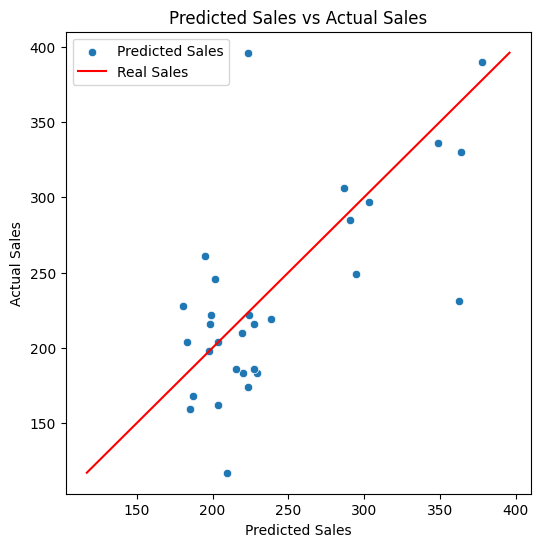

In [237]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot to visualize predicted sales vs real sales
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Predicted Sales")
ax.set_ylabel("Actual Sales")
sns.scatterplot(x=y_pred, y=y_test, ax=ax, label="Predicted Sales")
sns.lineplot(x=y_test, y=y_test, color="red", ax=ax, label="Real Sales")

<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Date', ylabel='Sales'>

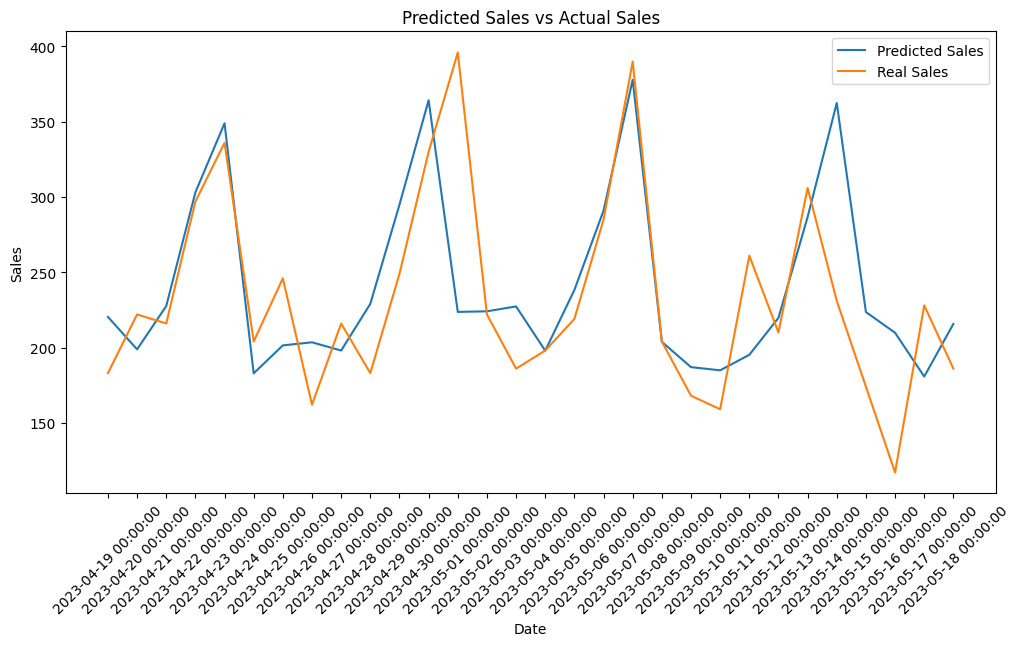

In [238]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_xticklabels(df_test["fecha_venta"], rotation=45)

dates = df_test["fecha_venta"].astype(str)
sns.lineplot(x=dates, y=y_pred, label="Predicted Sales")
sns.lineplot(x=dates, y=y_test, label="Real Sales")

## Deploy the model

In a terminal run the following command to deploy the model:

```bash
export MLFLOW_TRACKING_URI=http://localhost:5000
mlflow models serve -m models:/3960_sales_prediction@production -p 5001 --env-manager local
```

You should see something like this:

```bash
[INFO] Starting gunicorn 21.2.0
[INFO] Listening at: http://127.0.0.1:5001 (236041)
[INFO] Using worker: sync
[INFO] Booting worker with pid: 236048
```

It means it's working correctly 🎉

## Make requests to the model

The model is now deployed and ready to receive requests. We will make a request to the model using the test set.

- 👉 prepare the test set to be sent as JSON
- 👉 make a POST request to the model
- 👉 get the predictions from the response and show them

In [239]:
import requests
import json


URL = "http://127.0.0.1:5001/invocations"
headers = {"Content-Type": "application/json"}

df_send = df_test.copy()
df_send["fecha_venta"] = df_send["fecha_venta"].astype(str)

data = {
    "dataframe_split": {
        "columns": df_send.columns.tolist(),
        "index": df_send.index.to_list(),
        "data": df_send.values.tolist()
    }
}

response = requests.post(URL, headers=headers, data=json.dumps(data))
predictions = response.json()['predictions']

## Push Results to Database

We push the results to the database so we can visualize them using other tools like Tableau, PowerBI, etc.

Prepare the dataframe to upload to the database

In [240]:
dates = df_send["fecha_venta"].tolist()

# Create a dataframe with the data to store
df_article_prediction = pd.DataFrame({
    "fecha": dates,
    "cantidad": predictions,
    "articulo": [PRODUCT_ID] * len(predictions),  # repeat the article for each date
    "familia": [PRODUCT_FAMILY] * len(predictions),  # repeat the family for each date
})

df_article_prediction.head(5)

,fecha,cantidad,articulo,familia
0,2023-04-19,220.369854,3960,BOLLERIA
1,2023-04-20,198.799707,3960,BOLLERIA
2,2023-04-21,227.539331,3960,BOLLERIA
3,2023-04-22,303.055409,3960,BOLLERIA
4,2023-04-23,349.011303,3960,BOLLERIA


Push the dataframe to the database

In [241]:
# Database credentials
DATABASE = "sandbox"
NAME = "MarinaFinal"

table_name = f"Materials_Prediction_Group_{NAME}"

# Connect to the database
db = DatabaseConnection(USERNAME, PASSWORD, database=DATABASE)
db.insert_dataframe(df_article_prediction, table_name)